# Netflix Analysis and Recommendation System

In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163490 sha256=3aa9b1da5c586732504a1fce857646f6ef34d1d4891b150d126f0a37906db744
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import accuracy_score, classification_report

In [3]:
df = pd.read_csv('/content/netflix_titles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [4]:
# Bifercating 'duration' to "seasons" and 'Minutes"
df['duration_minutes'] = df['duration'].apply(lambda x: int(x.split(' ')[0]) if isinstance(x, str) and 'min' in x else None)
df['seasons'] = df['duration'].apply(lambda x: int(x.split(' ')[0]) if isinstance(x, str) and 'Season' in x else None)

In [5]:
# Handling missing values
df.fillna('', inplace=True)

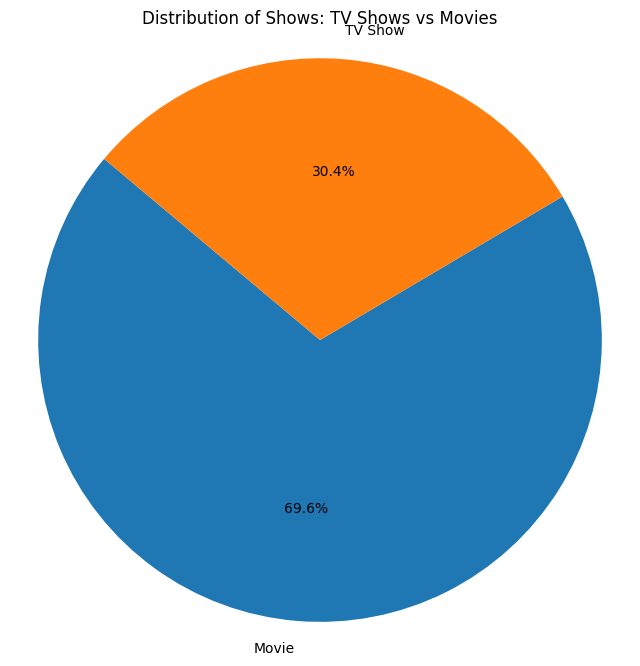

In [6]:
show_counts = df['type'].value_counts()

# Data for the pie chart
labels = show_counts.index
sizes = show_counts.values

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Shows: TV Shows vs Movies')
plt.show()

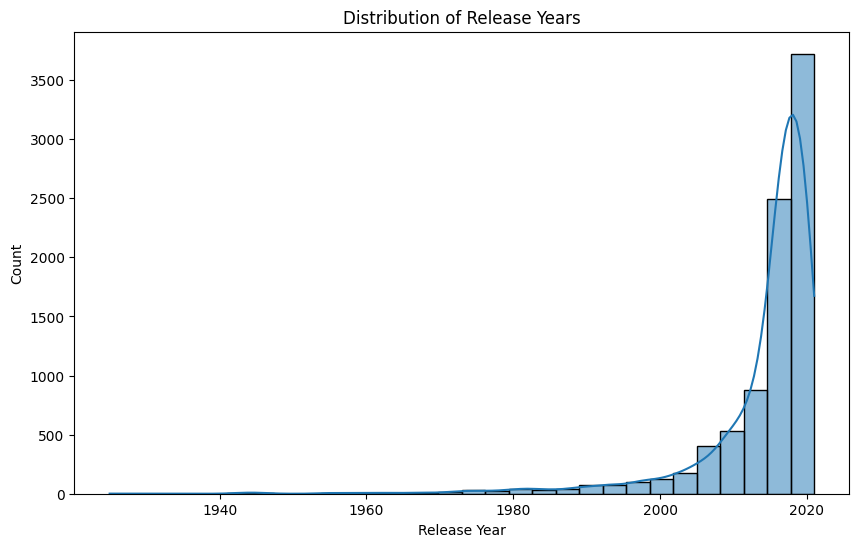

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['release_year'], bins=30, kde=True)
plt.xlabel('Release Year')
plt.title('Distribution of Release Years')
plt.show()

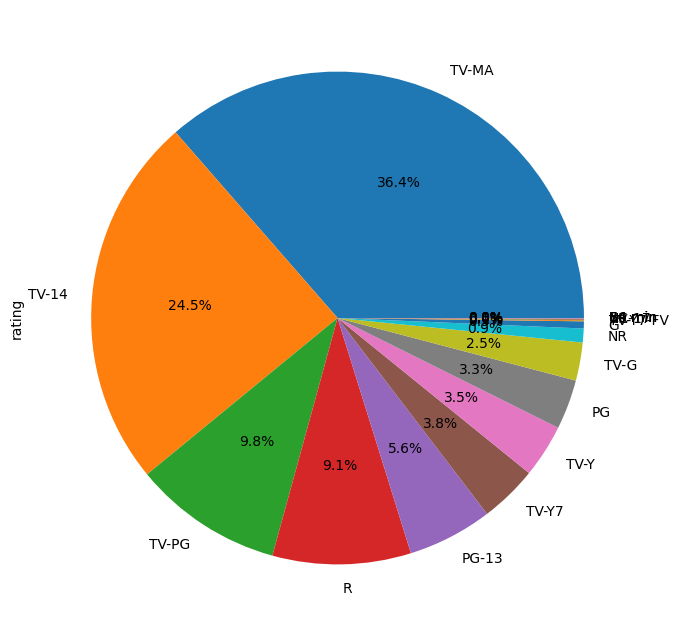

In [8]:
# df['rating'].value_counts().plot.pie(autopct='%1.1f%%',shadow=False,figsize=(10,8))
df['rating'].value_counts().plot(kind='pie', autopct = '%1.1f%%',figsize=(10,8))
plt.show()

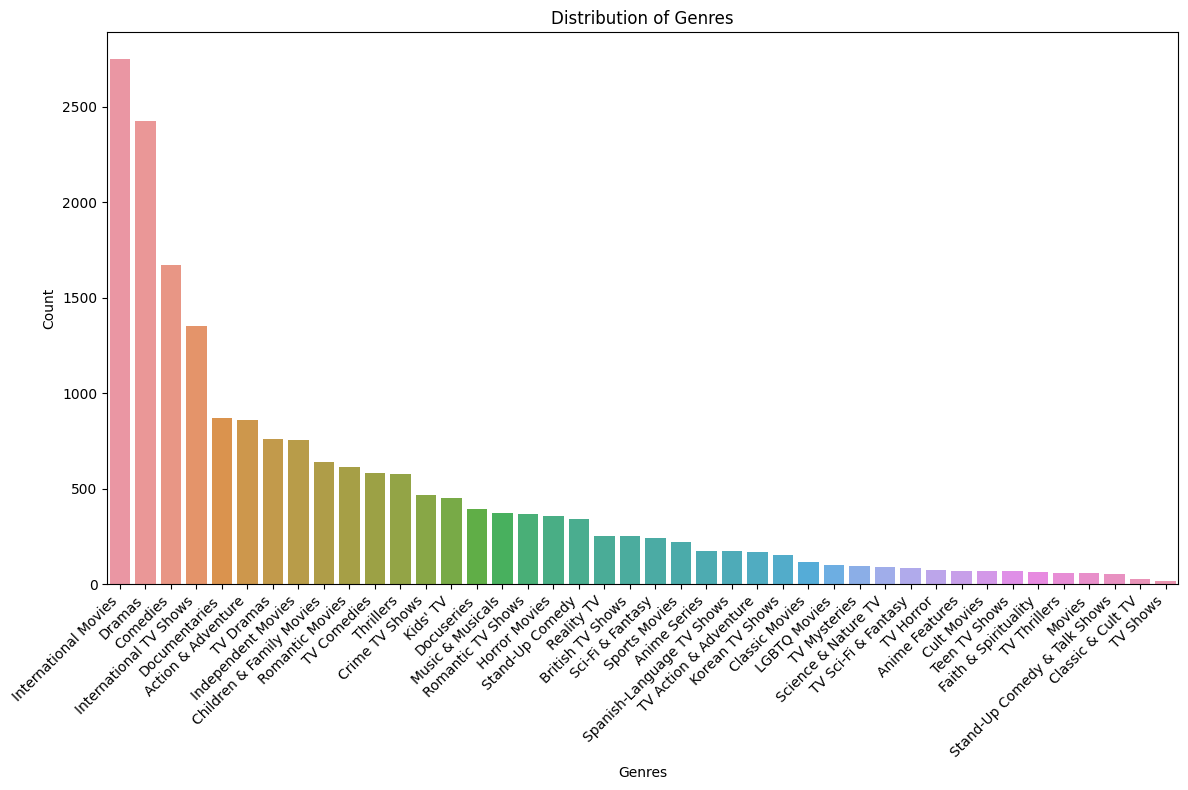

In [9]:
df['genres'] = df['listed_in'].apply(lambda x: x.split(', '))

# Create a list of all genres
all_genres = [genre for sublist in df['genres'] for genre in sublist]

genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x = genre_counts.index, y = genre_counts.values)
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Distribution of Genres')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

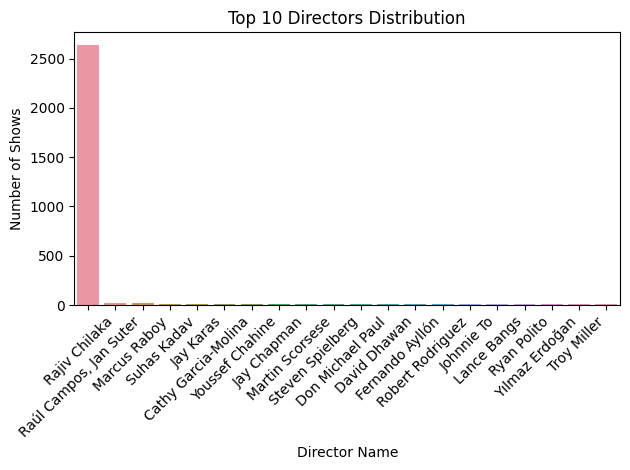

In [10]:
directors = df.groupby('director').size()
top_dir = directors.sort_values(ascending=False).head(20)
sns.barplot(x = top_dir.index, y = top_dir.values)
plt.xlabel('Director Name')
plt.ylabel('Number of Shows')
plt.title('Top 10 Directors Distribution')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

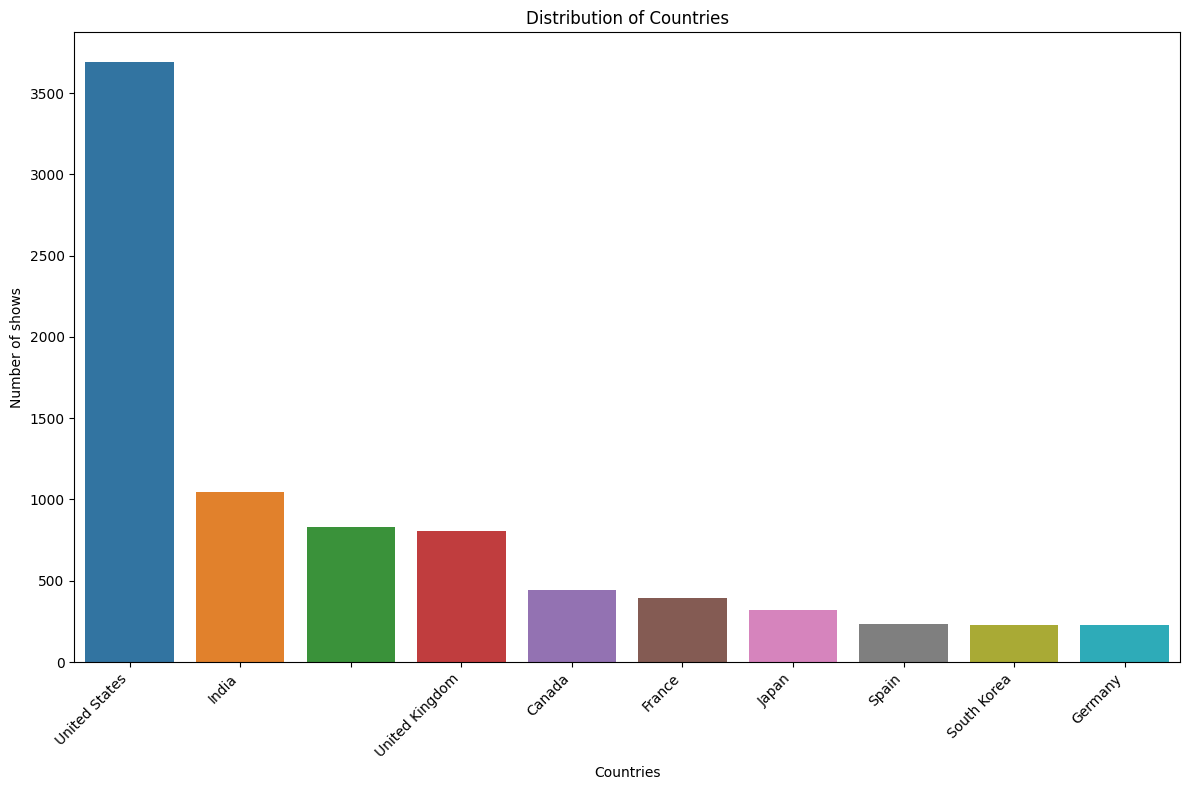

In [11]:
df['countries'] = df['country'].apply(lambda x: x.split(', '))

# Create a list of all countries
all_countries = [country for sublist in df['countries'] for country in sublist]

# Count the occurrences of each country
country_counts = pd.Series(all_countries).value_counts().head(10)

# Plotting the country counts
plt.figure(figsize=(12, 8))
sns.barplot(x = country_counts.index, y = country_counts.values)
plt.xlabel('Countries')
plt.ylabel('Number of shows')
plt.title('Distribution of Countries')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of shows')

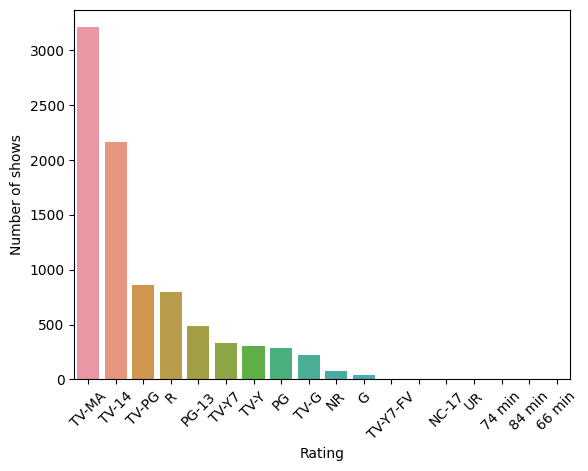

In [12]:
rating_counts = df['rating'].value_counts()
sns.barplot(x = rating_counts.index, y = rating_counts.values)
plt.xlabel('Rating')
plt.xticks(rotation = 45)
plt.ylabel('Number of shows')

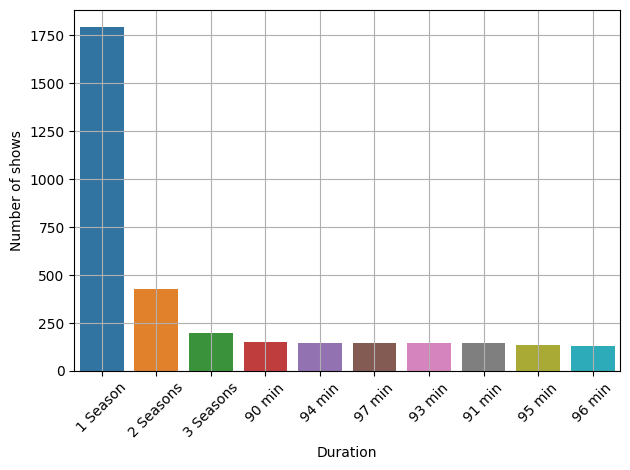

In [13]:
show_duration = df['duration'].value_counts().head(10)
sns.barplot(x = show_duration.index, y = show_duration.values)
plt.xlabel('Duration')
plt.ylabel('Number of shows')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

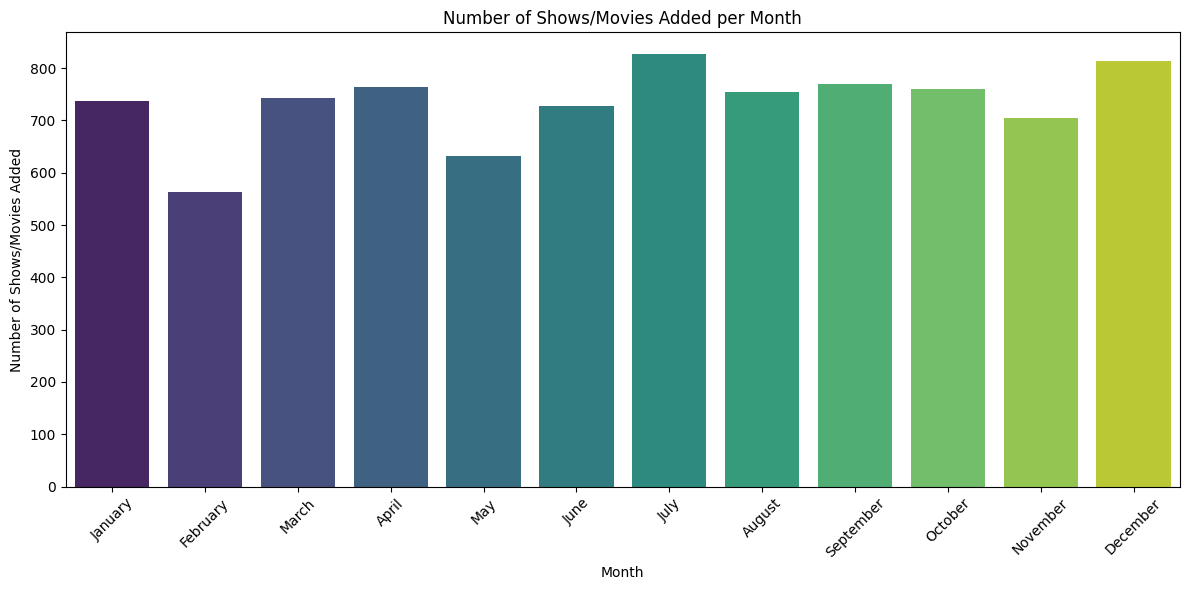

In [14]:
df['date_added'] = pd.to_datetime(df['date_added'])
df['month_added'] = df['date_added'].dt.month

monthly_counts = df.groupby('month_added').size()

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
               'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette='viridis')
plt.xlabel('Month')
plt.ylabel('Number of Shows/Movies Added')
plt.title('Number of Shows/Movies Added per Month')
plt.xticks(ticks=range(12), labels=month_names, rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Handling categorical variables
label_encoder = LabelEncoder()
df['rating'] = label_encoder.fit_transform(df['rating'])

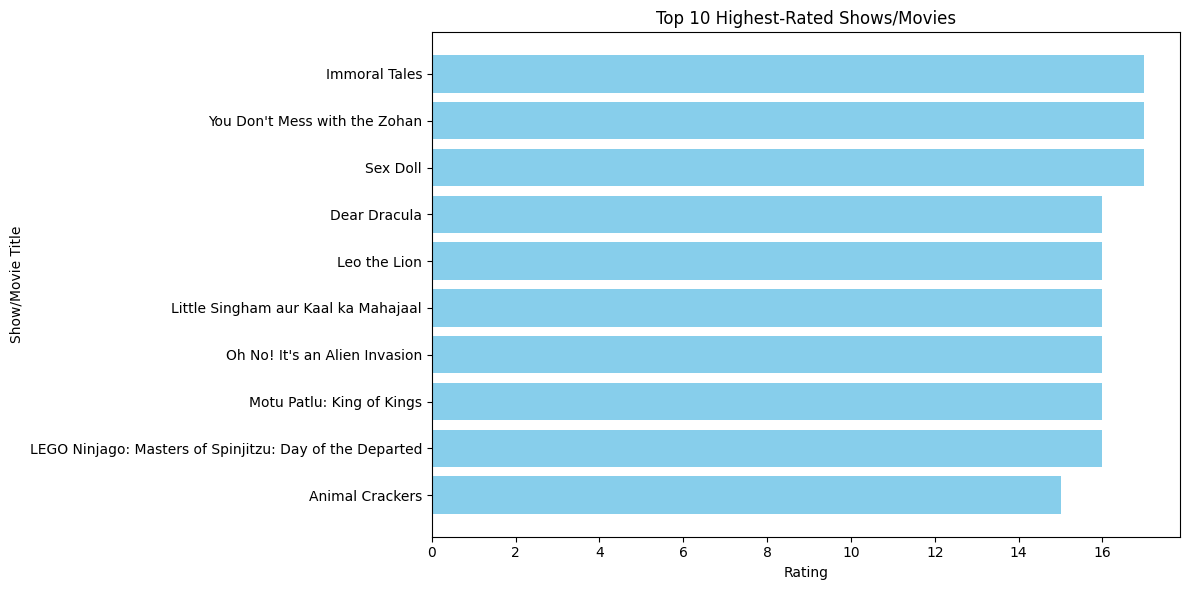

In [16]:
sorted_df = df.sort_values(by='rating', ascending=False)

top_n = 10
top_rated = sorted_df.head(top_n)

plt.figure(figsize=(12, 6))
plt.barh(top_rated['title'], top_rated['rating'], color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Show/Movie Title')
plt.title('Top {} Highest-Rated Shows/Movies'.format(top_n))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

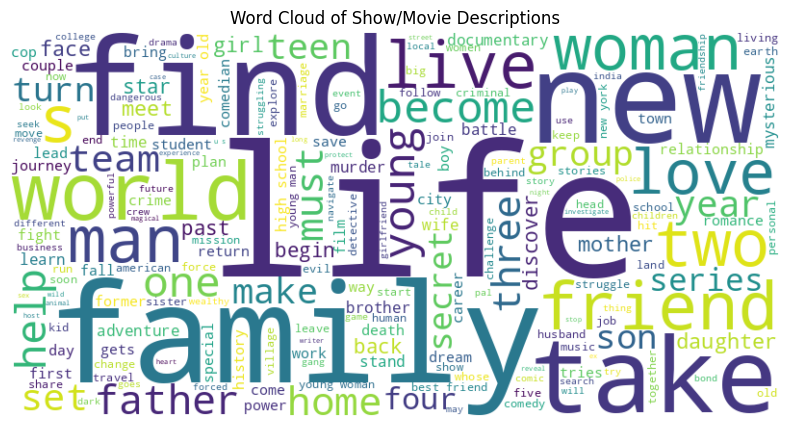

In [17]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
all_descriptions = ' '.join(df['description'].dropna())

stopwords = set(STOPWORDS)
processed_text = ' '.join([word.lower() for word in all_descriptions.split() if word.lower() not in stopwords])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Show/Movie Descriptions')
plt.show()

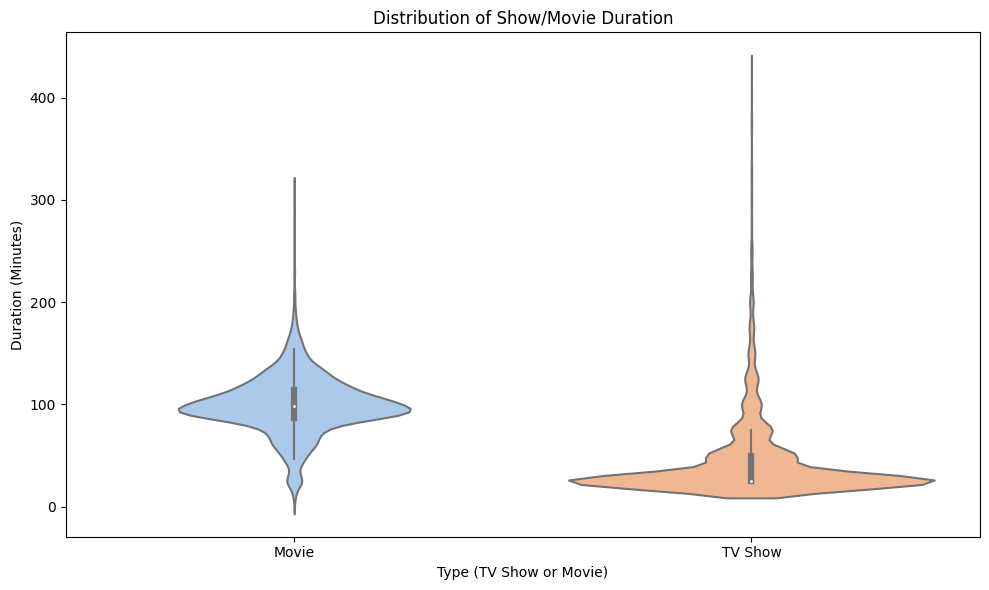

In [18]:
def duration_to_minutes(duration):
    if 'min' in duration:
        return int(duration.split(' ')[0])
    elif 'Season' in duration:
        return int(duration.split(' ')[0]) * 25

df['duration_minutes'] = df['duration'].apply(duration_to_minutes)

plt.figure(figsize=(10, 6))
sns.violinplot(x='type', y='duration_minutes', data=df, palette='pastel')
plt.xlabel('Type (TV Show or Movie)')
plt.ylabel('Duration (Minutes)')
plt.title('Distribution of Show/Movie Duration')
plt.tight_layout()
plt.show()

In [19]:
# Handling categorical variables
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])
df['rating'] = label_encoder.fit_transform(df['rating'])

# **Model Building**


In [20]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Combine relevant features which are required for training purposes
df['combined_features'] = df[['cast', 'description', 'director', 'country', 'title', 'listed_in']].apply(lambda x: ' '.join(x.dropna()), axis=1)
df['combined_features'] = df['combined_features'].str.lower()

# Fill missing values in numerical columns with mean values
numerical_columns = ['release_year']
imputer = SimpleImputer(strategy='mean')
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

# Train-test split into 70 and 30 respectively
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# TF-IDF Vectorization and removing stop words
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['combined_features'])

# Compute similarity matrix using linear kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get recommendations based on user input
def get_recommendations(user_input, similarity_matrix, data=train_data):
    user_input = user_input.lower()

    if user_input not in data['title'].str.lower().values and user_input not in data['director'].str.lower().values and user_input not in data['release_year'].astype(str).values:
        print(f"Error: '{user_input}' not found in the dataset.")
        return []

    # Find the index based on user input matching the values to title, director and release year
    if user_input in data['title'].str.lower().values:
        idx = data[data['title'].str.lower() == user_input].index[0]
    elif user_input in data['director'].str.lower().values:
        idx = data[data['director'].str.lower() == user_input].index[0]
    elif user_input in data['release_year'].astype(str).values:
        idx = data[data['release_year'].astype(str) == user_input].index[0]

    if idx >= len(similarity_matrix):
        print(f"Error: Index {idx} is out of bounds for axis 0 with size {len(similarity_matrix)}")
        return []

    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]  # Top 10 similar shows

    show_indices = [i[0] for i in sim_scores]
    return data['title'].iloc[show_indices].tolist()

# User input for recommendations
user_input = input("Enter a movie title, director name, or release year: ")
recommendations = get_recommendations(user_input, cosine_sim, data=train_data)
if recommendations:
    print(f"Recommendations for '{user_input}':")
    print(recommendations)

Enter a movie title, director name, or release year: s. shankar
Recommendations for 's. shankar':
['Wheels of Fortune', 'Riding Faith', 'The 2nd', 'Starship Troopers: Traitor of Mars', 'Greenhouse Academy', 'My Teacher, My Obsession', 'Belgica', 'Big Fat Liar', 'Go Karts', 'Operation Ouch!', 'Russell Madness', 'Furie', 'Speed Is My Need', 'Trolls: The Beat Goes On!', 'Eastsiders', 'A Shaun the Sheep Movie: Farmageddon', 'Final Destination', 'IO', 'Christina P: Mother Inferior', 'Formula 1: Drive to Survive']


In [21]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Combine relevant features which are required for training purposes
df['combined_features'] = df[['cast', 'description', 'director', 'country', 'title', 'listed_in']].apply(lambda x: ' '.join(x.dropna()), axis=1)
df['combined_features'] = df['combined_features'].str.lower()

# Impute missing values in numerical columns with mean values
numerical_columns = ['release_year']
imputer = SimpleImputer(strategy='mean')
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

# Create a user-item matrix
user_item_matrix = df.pivot_table(index='title', columns='director', values='release_year', fill_value=0)

# Apply Truncated SVD to reduce dimensionality
n_components = 200  # You can adjust this parameter
svd = TruncatedSVD(n_components=n_components)
svd_matrix = svd.fit_transform(user_item_matrix)

# Compute cosine similarity between items
cosine_sim_svd = cosine_similarity(svd_matrix, svd_matrix)

# Function to get recommendations based on user input
def get_recommendations_svd(user_input, similarity_matrix, data=df):
    user_input = user_input.lower()

    # Determine the type of user input (title, director, or release year)
    if user_input in data['title'].str.lower().values:
        input_type = 'title'
    elif user_input in data['director'].str.lower().values:
        input_type = 'director'
    elif user_input in data['release_year'].astype(str).values:
        input_type = 'release_year'
    else:
        print(f"Error: '{user_input}' not found in the dataset.")
        return []

    # Find the index based on the user input
    idx = None
    if input_type == 'title':
        idx = data[data['title'].str.lower() == user_input].index[0]
    elif input_type == 'director':
        idx = data[data['director'].str.lower() == user_input].index[0]
    elif input_type == 'release_year':
        idx = data[data['release_year'].astype(str) == user_input].index[0]

    if idx >= len(similarity_matrix):
        print(f"Error: Index {idx} is out of bounds for axis 0 with size {len(similarity_matrix)}")
        return []

    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]  # Top 10 similar shows

    show_indices = [i[0] for i in sim_scores]
    return data['title'].iloc[show_indices].tolist()

# User input for recommendations using SVD
user_input_svd = input("Enter a movie title, director name, or release year: ")
recommendations_svd = get_recommendations_svd(user_input_svd, cosine_sim_svd, data=df)
if recommendations_svd:
    print(f"Recommendations for '{user_input_svd}':")
    print(recommendations_svd)

Enter a movie title, director name, or release year: s. shankar
Recommendations for 's. shankar':
['Je Suis Karl', 'Crime Stories: India Detectives', 'Monsters Inside: The 24 Faces of Billy Milligan', 'Resurrection: Ertugrul', 'Avvai Shanmughi', 'Jeans', 'Grown Ups', 'Ankahi Kahaniya', 'Squid Game', 'Tayo and Little Wizards', 'Angry Birds', 'Dharmakshetra', 'Naruto Shippuden: The Movie: The Lost Tower', 'Naruto the Movie 3: Guardians of the Crescent Moon Kingdom', 'Saved by the Bell', 'Schumacher', 'Stories by Rabindranath Tagore', 'Firedrake the Silver Dragon', 'Blood Brothers: Malcolm X & Muhammad Ali', 'The Women and the Murderer']


# Evaluation Metrics

In [22]:
engagement_threshold = 4.5

# Assume engagement_label = 1 if rating is above the threshold, else 0
df['engagement_label'] = (df['rating'].apply(lambda x: 1 if x >= engagement_threshold else 0)).astype(int)

# Define features and target
X = df[['type', 'release_year', 'duration_minutes', 'seasons', 'rating']]
y = df['engagement_label']

# Handle missing values
X.fillna(0, inplace=True)

# Convert non-numeric values to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Handle any remaining missing values
X.fillna(0, inplace=True)

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest Classifier model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Classifier Accuracy: {accuracy_rf:.2f}')
print('Classification Report for Random Forest Classifier:')
print(classification_report(y_test, y_pred_rf))

# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f'Logistic Regression Accuracy: {accuracy_logistic:.2f}')
print('Classification Report for Logistic Regression:')
print(classification_report(y_test, y_pred_logistic))

# Initialize and train the Support Vector Machines model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the Support Vector Machines model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Support Vector Machines Accuracy: {accuracy_svm:.2f}')
print('Classification Report for Support Vector Machines:')
print(classification_report(y_test, y_pred_svm))


<ipython-input-22-10476c813ac6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Random Forest Classifier Accuracy: 1.00
Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00      2624

    accuracy                           1.00      2643
   macro avg       1.00      1.00      1.00      2643
weighted avg       1.00      1.00      1.00      2643

Logistic Regression Accuracy: 1.00
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00      2624

    accuracy                           1.00      2643
   macro avg       1.00      1.00      1.00      2643
weighted avg       1.00      1.00      1.00      2643

Support Vector Machines Accuracy: 0.99
Classification Report for Support Vector Machines:
              precision    recall  f1-score   support

           0       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix


accuracy_rf = accuracy_score(y_test, y_pred_rf)
confusion_rf = confusion_matrix(y_test, y_pred_rf)

precision_rf = confusion_rf[1, 1] / (confusion_rf[1, 1] + confusion_rf[0, 1])
recall_rf = confusion_rf[1, 1] / (confusion_rf[1, 1] + confusion_rf[1, 0])
f1_score_rf = 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf)

print('Confusion Matrix for Random Forest Classifier:')
print(confusion_rf)
print(f'F1 Score: {f1_score_rf:.2f}')


Confusion Matrix for Random Forest Classifier:
[[  19    0]
 [   0 2624]]
F1 Score: 1.00
